In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

from datetime import datetime
from tqdm import tqdm
import os

from datasets import load_dataset, DatasetDict, concatenate_datasets
import wandb

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import json
from huggingface_hub import HfApi, Repository

In [21]:
wandb_api_key = os.getenv('WANDB_API_KEY')
hf_token = os.getenv('HF_TOKEN')

In [11]:
wandb.login(key=wandb_api_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
wandb.init(project="trash-classification", config={
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 3,
    "model": "ResNet18",
})

wandb: Currently logged in as: ardhanaputrawibowo (ardhanaputrawibowo-stuff). Use `wandb login --relogin` to force relogin


In [ ]:
CONFIG = wandb.config

In [15]:
dataset = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

# Exploratory Data Analysis

In [ ]:
#EDA

#Median image size
#tidak digunakan karena waktu running yang terlalu lama (20 menit)
"""
image_sizes = []

for data in dataset['train'].select(range(300)):
  image = data['image']
  image_sizes.append((image.shape[1], image.shape[2]))

heights = [size[0] for size in image_sizes]
widths = [size[1] for size in image_sizes]

median_height = np.median(heights)
median_width = np.median(widths)

print(f"Median Image Size: {median_height}x{median_width}")
"""

Median Image Size: 3024.0x3264.0


In [16]:
dataset.unique('label')

{'train': [0, 1, 2, 3, 4, 5]}

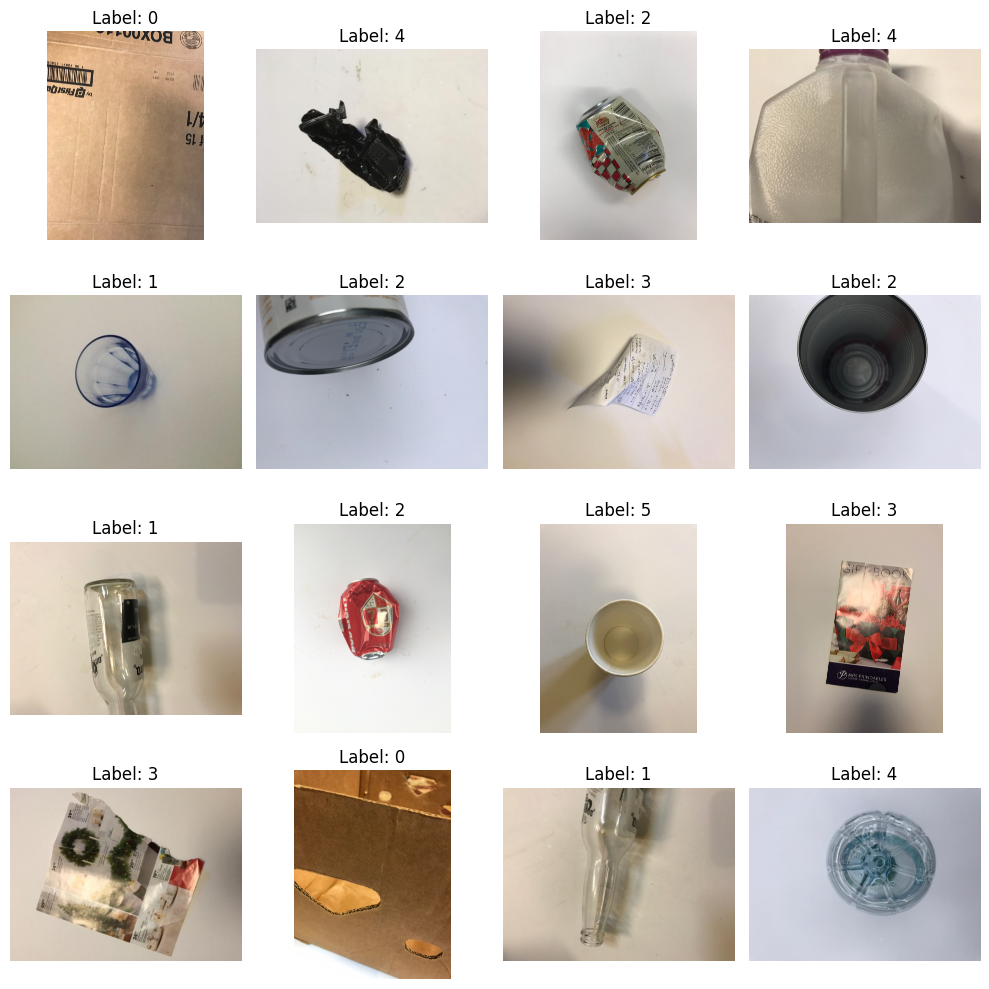

In [ ]:
#Show image samples
grid_size = 4
num_samples = grid_size * grid_size

sample = dataset['train'].shuffle(seed=42).select(range(num_samples))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image = sample[i]['image']
    label = sample[i]['label']

    ax.imshow(image)
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [17]:
print("Jumlah gambar class 0 ('cardboard'): ", len([label for label in dataset['train']['label'] if label == 0]))
print("Jumlah gambar class 1 ('glass'): ", len([label for label in dataset['train']['label'] if label == 1]))
print("Jumlah gambar class 2 ('metal'): ", len([label for label in dataset['train']['label'] if label == 2]))
print("Jumlah gambar class 3 ('paper'): ", len([label for label in dataset['train']['label'] if label == 3]))
print("Jumlah gambar class 4 ('plastic'): ", len([label for label in dataset['train']['label'] if label == 4]))
print("Jumlah gambar class 5 ('trash'): ", len([label for label in dataset['train']['label'] if label == 5]))

Jumlah gambar class 0 ('cardboard'):  806
Jumlah gambar class 1 ('glass'):  1002
Jumlah gambar class 2 ('metal'):  820
Jumlah gambar class 3 ('paper'):  1188
Jumlah gambar class 4 ('plastic'):  964
Jumlah gambar class 5 ('trash'):  274


# Data Preparation

In [ ]:
dataset.set_format("torch")

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})

In [ ]:
#ds = dataset['train'].select(range(100))

In [ ]:
#Augment
augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.ToTensor(),
])

def augment(img):
    img["image"] = augmentation(img['image'])
    return img

In [ ]:
#ds = ds.map(augment)
ds = dataset['train'].map(augment)

In [ ]:
#Preprocessing
ds_train_temp = []
ds_val_temp = []
ds_test_temp = []

for label in ds.unique('label'):
  ds_by_class = ds.filter(lambda x: x['label'] == label)

  ds_by_class_train = ds_by_class.train_test_split(test_size=0.2)
  ds_by_class_val_test = ds_by_class_train['test'].train_test_split(test_size=0.5)

  ds_train_temp.append(ds_by_class_train['train'])
  ds_val_temp.append(ds_by_class_val_test['train'])
  ds_test_temp.append(ds_by_class_val_test['test'])

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
ds_train = concatenate_datasets(ds_train_temp)
ds_val = concatenate_datasets(ds_val_temp)
ds_test = concatenate_datasets(ds_test_temp)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=CONFIG.batch_size)
val_dataloader = torch.utils.data.DataLoader(ds_val, shuffle=False, batch_size=CONFIG.batch_size)
test_dataloader = torch.utils.data.DataLoader(ds_test, shuffle=False, batch_size=CONFIG.batch_size)

# Training & Evaluating Model, Logging Training Results to wandb


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet18(pretrained=True)
#model.fc = torch.nn.Linear(model.fc.in_features, len(ds['train'].features['label'].names))
#model.fc = torch.nn.Linear(model.fc.in_features, 1)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate)

# Training phase
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
  for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0

      for batch in tqdm(train_dataloader, desc='Training loop'):
          images, labels = batch['image'].to(device), batch['label'].to(device)

          optimizer.zero_grad()
          outputs = model(images.type(torch.FloatTensor))
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      train_accuracy = 100 * correct / total
      val_loss, val_accuracy = evaluate_model(model, val_dataloader, criterion)

      wandb.log({
          "epoch": epoch + 1,
          "train_loss": running_loss / len(train_dataloader.dataset),
          "train_accuracy": train_accuracy,
          "val_loss": val_loss,
          "val_accuracy": val_accuracy,
      })

      print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, "
            f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

# Validation phase
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc='Validation loop'):
            images, labels = batch['image'].to(device), batch['label'].to(device)

            outputs = model(images.type(torch.FloatTensor))
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_dataloader.dataset)

    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
 93%|█████████▎| 41.4M/44.7M [00:00<00:00, 58.5MB/s]


KeyboardInterrupt: 

In [ ]:
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, CONFIG.epochs)

In [ ]:
test_set_loss, test_set_accuracy = evaluate_model(model, test_dataloader, criterion)
print(f"Akurasi pada test set: {test_set_accuracy:.2f}%")
print(f"Loss pada test set: {test_set_loss:.2f}%")

In [19]:
os.makedirs("model_dir", exist_ok=True)
torch.save(model.state_dict(), "model_dir/trashClassifier.pth")

NameError: name 'model' is not defined

# Publishing the model to Hugging Face

In [18]:
config = {
    "input_size": 224,
    "num_classes": 6,
    "architecture": "resnet18",
    "framework": "pytorch"
}

with open("model_dir/config.json", "w") as f:
    json.dump(config, f)

FileNotFoundError: [Errno 2] No such file or directory: 'model_dir/config.json'

In [25]:
repo_name = "trash-classifier"
username = "ardhanapw"
repo_id = f"{username}/{repo_name}"

# Create a repository if it doesn't already exist
api = HfApi(token=hf_token)
api.create_repo(repo_id=repo_id, exist_ok=True)

api.upload_file(
    path_or_fileobj="model_dir/trashClassifier.pth",
    path_in_repo="model.pth",
    repo_id=repo_id
)

api.upload_file(
    path_or_fileobj="model_dir/config.json",
    path_in_repo="config.json",
    repo_id=repo_id
)

ValueError: Provided path: 'model_dir/trashClassifier.pth' is not a file on the local file system